In [1]:
from helper_loader import *

In [2]:
volume_shape = load_volume(get_atlas_path(Resolution.MICRONS_100)).shape
update_cameras(volume_shape)
update_axes(volume_shape)

array = np.zeros(shape=volume_shape, dtype=np.uint8)
array[:, (volume_shape[1] - 1) // 2, (volume_shape[2] - 1) // 2] = 1
# array[:, :, (volume_shape[2] - 1) // 2] = 1

volume = vedo.Volume(array)

In [3]:
settings = VolumeSettings(
    orientation=Orientation.CORONAL,
    resolution=Resolution.MICRONS_100,
    offset=50,
    pitch=20,
    yaw=50,
    shape=volume_shape,
)

In [4]:
image = VolumeSlicer(volume=volume).slice(settings, return_mesh=False, autocrop=False)
mesh = VolumeSlicer(volume=volume).slice(settings, return_mesh=True, autocrop=False)

original_mesh_center = np.array(
    [
        (mesh.metadata["original_bounds"][1] + mesh.metadata["original_bounds"][0])
        // 2,
        (mesh.metadata["original_bounds"][3] + mesh.metadata["original_bounds"][2])
        // 2,
        (mesh.metadata["original_bounds"][5] + mesh.metadata["original_bounds"][4])
        // 2,
    ]
)

In [5]:
image.shape

(167, 207)

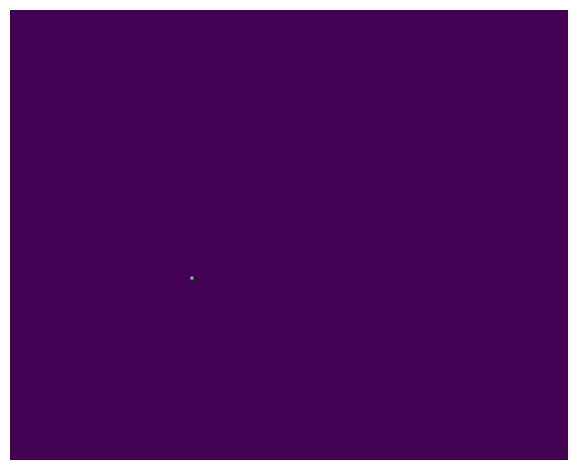

In [6]:
imshow(image)

In [7]:
image = np.pad(
    image,
    [
        # [0, 0],
        [0, 2 * -int(original_mesh_center[1])],
        # [int(original_mesh_center[0]), 0],
        # [0, 0],
        # [-int(original_mesh_center[1]), 0],
        [2 * int(original_mesh_center[0]), 0],
    ],
)

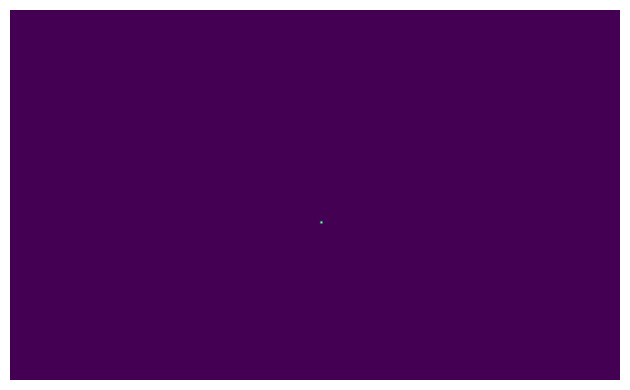

In [8]:
# image[(image.shape[0] - 1) // 2] = 2
# image[:, (image.shape[1] - 1) // 2] = 2

imshow(image)

# Clean up

In [43]:
def get_image_from_slice_mesh(mesh: vedo.Mesh, settings: VolumeSettings) -> np.ndarray:
    image = mesh.pointdata["ImageScalars"].reshape(mesh.metadata["shape"])

    if settings.orientation == Orientation.HORIZONTAL:
        image = ndimage.rotate(image, -90)
    if settings.orientation != Orientation.SAGITTAL:
        image = ndimage.rotate(image, settings.pitch)

    return image


def slice_image(volume: vedo.Volume, settings: VolumeSettings) -> np.ndarray:
    mesh = VolumeSlicer(volume=volume).slice(settings, return_mesh=True, autocrop=False)
    image = get_image_from_slice_mesh(mesh, settings)

    original_mesh_center = np.array(
        [
            (mesh.metadata["original_bounds"][1] + mesh.metadata["original_bounds"][0])
            // 2,
            (mesh.metadata["original_bounds"][3] + mesh.metadata["original_bounds"][2])
            // 2,
            (mesh.metadata["original_bounds"][5] + mesh.metadata["original_bounds"][4])
            // 2,
        ]
    )

    if (padding := int(original_mesh_center[0])) > 0:
        j_padding = [2 * padding, 0]
    else:
        j_padding = [0, 2 * -padding]

    if (padding := int(original_mesh_center[1])) > 0:
        i_padding = [10 * padding, 0]
    else:
        i_padding = [0, 10 * -padding]

    return np.pad(image, [i_padding, j_padding])

In [39]:
resolution = Resolution.MICRONS_25

volume = load_volume(get_atlas_path(resolution))
update_cameras(volume.shape)
update_axes(volume.shape)

# volume.tonumpy()[:] = 0
volume.tonumpy()[:, (volume.shape[1] - 1) // 2, (volume.shape[2] - 1) // 2] = 255
volume.tonumpy()[:, :, (volume.shape[2] - 1) // 2] = 255

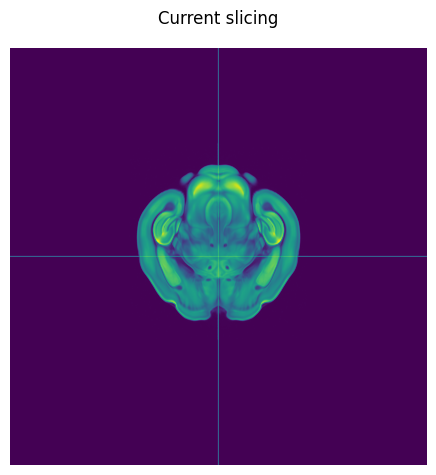

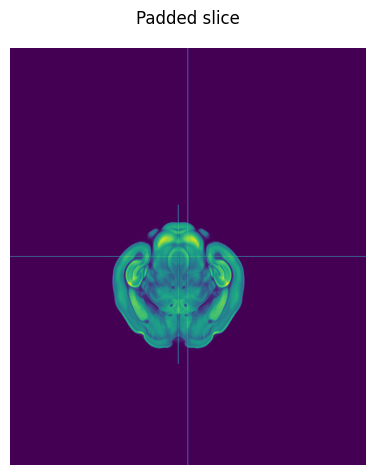

In [42]:
settings = VolumeSettings(
    orientation=Orientation.CORONAL,
    resolution=resolution,
    offset=-50,
    pitch=50,
    yaw=0,
    shape=volume.shape,
)

current_slicing_image = VolumeSlicer(volume=volume).slice(
    settings, return_mesh=False, autocrop=False
)
current_slicing_image[(current_slicing_image.shape[0] - 1) // 2] = 255
current_slicing_image[:, (current_slicing_image.shape[1] - 1) // 2] = 255

padded_slice_image = slice_image(volume, settings)
padded_slice_image[(padded_slice_image.shape[0] - 1) // 2] = 255
padded_slice_image[:, (padded_slice_image.shape[1] - 1) // 2] = 255

imshow(current_slicing_image, title="Current slicing")
imshow(padded_slice_image, title="Padded slice")